## CUSTO SOCIAL DA REDISTRIBUIÇÃO (BALDE FURADO DE OKUN)


In [17]:
# bibliotecas usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_excel(r'C:\{estudos}\ESP\Economia-do-Setor-Publico-2025.2\Aplicação 5\ESP_2025_PNADC2022.xlsx')

# Força a coluna NUM_DOM a virar número. Se tiver erro, vira NaN.
df['NUM_DOM'] = pd.to_numeric(df['NUM_DOM'], errors='coerce')
# Remove linhas onde NUM_DOM ficou vazio (NaN) ou é zero para evitar divisão por zero
df = df[df['NUM_DOM'] > 0].copy()
    
# ==============================================================================
# 1. CALCULO DA RENDA DOMICILIAR
# ============================================
# # Filtra apenas as condições válidas de moradores
df_filtrado = df[(df['CONDICAO'] >= 1) & (df['CONDICAO'] <= 16)].copy()

# Agrupa por ID do domicílio e soma a renda individual
renda_domiciliar = df_filtrado.groupby('ID_DOM')['RENDA_IND'].sum().reset_index()
renda_domiciliar.rename(columns={'RENDA_IND': 'RENDA_DOM'}, inplace=True)

# Mescla a renda domiciliar de volta ao dataframe original (semelhante ao MODE=ADDVARIABLES)
df = df.merge(renda_domiciliar, on='ID_DOM', how='left')

# ==============================================================================
# 2. CALCULO DA RENDA DOMICILIAR PER CAPITA
# ==============================================================================

df['RDBPC'] = df['RENDA_DOM'] / df['NUM_DOM']

# ==============================================================================
# 3 e 4. CRIACAO DOS DECIMOS E VARIAVEL DECIL
# ==============================================================================

# No Python, usamos qcut para dividir em decis automaticamente
# labels=range(1, 11) cria categorias de 1 a 10
try:
    df['DECIL'] = pd.qcut(df['RDBPC'], q=10, labels=range(1, 11))
except ValueError:
    print("Erro ao calcular decis: verifique se há valores suficientes ou únicos na renda.")

# Exibir os cortes (percentis) para conferência (equivalente ao output do passo 3 do SPSS)
percentis = df['RDBPC'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).to_frame(name='Corte de Renda')
print("\n--- Cortes dos Decis (Percentis) ---")
display(percentis)

# ==============================================================================
# 5. CALCULO DA RENDA DOMICILIAR MEDIA POR DECIL
# ==============================================================================

tabela_medias = df.groupby('DECIL', observed=True)['RDBPC'].mean().reset_index()
tabela_medias.rename(columns={'RDBPC': 'MEDIA_RENDA_PER_CAPITA'}, inplace=True)

print("\n--- Média de Renda Domiciliar Per Capita por Decil ---")
display(tabela_medias)

# ==============================================================================
# 6. CALCULO DA RAZAO (DECIL 10 / DECIL 1)
# ==============================================================================
media_d10 = tabela_medias.loc[tabela_medias['DECIL'] == 10, 'MEDIA_RENDA_PER_CAPITA'].values[0]
media_d1 = tabela_medias.loc[tabela_medias['DECIL'] == 1, 'MEDIA_RENDA_PER_CAPITA'].values[0]

razao = media_d10 / media_d1
print(f"\nRazão (Renda D10 / Renda D1): {razao:.2f}")


--- Cortes dos Decis (Percentis) ---


,Corte de Renda
0.1,333.333333
0.2,500.000000
0.3,633.000000
0.4,806.000000
0.5,1000.000000
0.6,1212.000000
0.7,1444.800000
0.8,1900.000000
0.9,2926.333333



--- Média de Renda Domiciliar Per Capita por Decil ---


,DECIL,MEDIA_RENDA_PER_CAPITA
0,1,203.150077
1,2,424.654980
2,3,577.582900
3,4,723.448911
4,5,900.119768
5,6,1149.910971
6,7,1321.831390
7,8,1653.788402
8,9,2325.216083
9,10,5882.419651



Razão (Renda D10 / Renda D1): 28.96


In [12]:
# ==============================================================================
# 7. CALCULO DO CUSTO SOCIAL MARGINAL (HARBERGER / OKUN)
# ==============================================================================
# Parâmetro de aversão à desigualdade (epsilon)
epsilon = 0.5

# Cálculo da razão de utilidades marginais: (Y_rico / Y_pobre)^epsilon
ratio_umg = razao ** epsilon

# Interpretação: UmgPobre = ratio_umg * UmgRico
# Custo Marginal Social = (ratio_umg - 1) / ratio_umg
# Ou simplificando como no enunciado: "Quanto do balde vaza"
# Se UmgP = 4 * UmgR, para entregar 1 de utilidade ao pobre, tiramos do rico.
# A sociedade tolera perder até X% no caminho.

custo_vazamento = 1 - (1 / ratio_umg)

print(f"\n--- Resultados Método Harberger (e={epsilon}) ---")
print(f"Parâmetro de Aversão (e): {epsilon}")
print(f"Peso Social Relativo (UmgP / UmgR): {ratio_umg:.2f}")
print(f"Isso significa que a utilidade marginal da renda do pobre é {ratio_umg:.2f}x maior que a do rico.")
print(f"Custo Marginal Social (Vazamento Aceitável): {custo_vazamento:.2%}")
print(f"Interpretação: A sociedade estaria disposta a aceitar que até {custo_vazamento*100:.1f}% da transferência 'vaze' (se perca) para reduzir a desigualdade.")


--- Resultados Método Harberger (e=0.5) ---
Parâmetro de Aversão (e): 0.5
Peso Social Relativo (UmgP / UmgR): 5.38
Isso significa que a utilidade marginal da renda do pobre é 5.38x maior que a do rico.
Custo Marginal Social (Vazamento Aceitável): 81.42%
Interpretação: A sociedade estaria disposta a aceitar que até 81.4% da transferência 'vaze' (se perca) para reduzir a desigualdade.


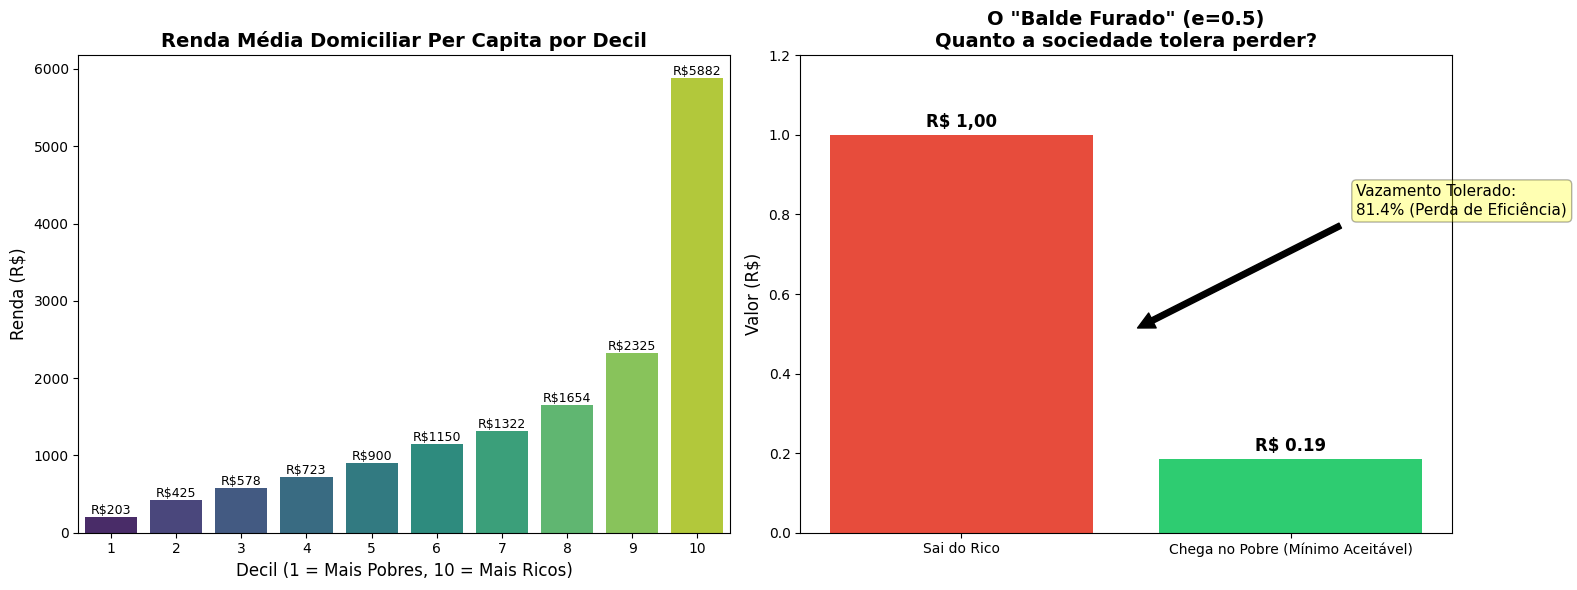

In [20]:
# ==============================================================================
# 6. GERAÇÃO DOS GRÁFICOS
# ==============================================================================

# Cria uma figura com 2 gráficos (um ao lado do outro)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- GRÁFICO 1: A Desigualdade de Renda por Decil ---
sns.barplot(x='DECIL', y='MEDIA_RENDA_PER_CAPITA', data=tabela_medias, ax=ax1, palette="viridis", hue='DECIL', legend=False)
ax1.set_title('Renda Média Domiciliar Per Capita por Decil', fontsize=14, fontweight='bold')
ax1.set_ylabel('Renda (R$)', fontsize=12)
ax1.set_xlabel('Decil (1 = Mais Pobres, 10 = Mais Ricos)', fontsize=12)

# Adiciona os valores em cima das barras
for index, row in tabela_medias.iterrows():
    ax1.text(row.name, row.MEDIA_RENDA_PER_CAPITA, f'R${row.MEDIA_RENDA_PER_CAPITA:.0f}', color='black', ha="center", va="bottom", fontsize=9)


# --- GRÁFICO 2: O Balde Furado (Custo Social) ---
# Dados para o gráfico
categorias = ['Sai do Rico', 'Chega no Pobre (Mínimo Aceitável)']
valores = [1.00, (1.00 - custo_vazamento)]
cores = ['#e74c3c', '#2ecc71'] # Vermelho e Verde

ax2.bar(categorias, valores, color=cores)
ax2.set_title(f'O "Balde Furado" (e={epsilon})\nQuanto a sociedade tolera perder?', fontsize=14, fontweight='bold')
ax2.set_ylabel('Valor (R$)', fontsize=12)
ax2.set_ylim(0, 1.2) # Dá um espaço extra no topo

# Adiciona labels explicativos
ax2.text(0, 1.02, "R$ 1,00", ha='center', fontweight='bold', fontsize=12)
ax2.text(1, valores[1] + 0.02, f"R$ {valores[1]:.2f}", ha='center', fontweight='bold', fontsize=12)

# Desenha o "Vazamento"
ax2.annotate(f'Vazamento Tolerado:\n{custo_vazamento*100:.1f}% (Perda de Eficiência)', 
             xy=(0.5, 0.5), xytext=(1.2, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=11, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.tight_layout()
plt.show()